# Part 2: Genres and communities and plotting

### The questions below are based on Lecture 7, part 2.

1. Write about genres and modularity.
2. Detect the communities, discuss the value of modularity in comparison to the genres.
3. Calculate the matrix  and discuss your findings.
4. Plot the communities and comment on your results.

------

# Genres and Modularity

## Modularity of a Network Partition

Modularity is able to provide a quantitative measure of how well a partition captures the commmunity structure. It does this y comparing the real link density in the network with what would be expected from that network if randomlu connected. [1]

In this case, for our rock artist network, we try to see if a certain artist's (or band's) genre create meaningful communities within the network. We will work on three different partitions: 

1. Partition 1 - where we take the artit's **primary genre** (the first listed on their wiki's infobox);
2. Partition 2 - where we **randomly select one** of the artit's listed genres
3. Partition 3 - this one using the **louvain community** detection method, and not the genres [11]

For a network with total links \(L\), partitioned into communities, its modularity is defined as:

$$ Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_i k_j}{2m} \right) \delta(c_i, c_j) $$

Where:  
- $A_{ij}$ = adjacency matrix (1 if nodes $i$ and $j$ are connected, 0 otherwise)
- $k_i$ = degree of node $i$  
- $m$ = total number of edges in the network  
- $\delta(c_i, c_j)$ = 1 if nodes $i$ and $j$ are in the same community, 0 otherwise
- The sum is over all pairs of nodes

We can look at modularity values and interpret them as:
- $Q > 0$ → more internal links than expected by chance ("strong" community partition)  
- $Q \approx 0$ → like random  
- $Q < 0$ → fewer internal links than expected ("bad" community partition)

Modularity was calculated using NetworkX's `modularity()` function [12].

#### Modularity in the rock artists network

If artists primarily connect to others within their genre (in this case, being referenced in each others pages for collaborations, influences, or shared characteristics) we would expect genre-based partitions to yield positive modularity values, indicating denser internal connections than random chance would predict.

Since the Louvain algorithm directly maximizes modularity [11], we expect that partition to result in the highest value. On the other hand, the randomly selected genre should yield the lowest modularity results.  

The primary genre partition modularity would, in principle, be in the middle of these two. The primary genre of an artist should in some ways connect it to others of the same genre, and that connectiviry patterns would be captured in the calculation of this metric. However, this value will not be as high as that of the Louvain partition, since genre classifications are not designed to optimize modularity and they don't allow for cross-genre connections. 

This highlights how culturally meaningful categories (such as genres) and mathematically optimal partitions do not necessarily match.


---

In [5]:
# Importing necessary libraries
import os
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle as pkl
from networkx.algorithms.community.quality import modularity
from matplotlib.pylab import partition
from collections import Counter
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score


### Extracting the genres from each artist's infobox
As suggested in the lecture notes, an LLM was used to generate the code for this task (Extracting evey artit's genre from the infobox in. their wikipedia page). 

The output file was inspected and validated before proceeding.

The code used is in the hidden cell bellow for reference.

In [6]:
## GENRE EXTRACTION CODE (HIDDEN) ## 
# def normalize_genre(genre):
#     """Normalize genre names to handle variations."""
#     genre = genre.lower().strip()
    
#     # Mapping for common variations
#     genre_mappings = {
#         "rock'n'roll": "rock and roll",
#         "rock & roll": "rock and roll",
#         "rock 'n' roll": "rock and roll",
#         "rock n roll": "rock and roll",
#         "r&b": "rhythm and blues",
#         "r & b": "rhythm and blues",
#         "hip-hop": "hip hop",
#         "drum'n'bass": "drum and bass",
#         "drum & bass": "drum and bass",
#     }
    
#     return genre_mappings.get(genre, genre)

# def get_wikipedia_url(artist_name):
#     """Convert artist name to Wikipedia URL."""
#     # Replace spaces with underscores and handle special characters
#     url_name = artist_name.replace(" ", "_")
#     return f"https://en.wikipedia.org/wiki/{url_name}"

# def extract_genres_from_infobox(artist_name):
#     """
#     Extract genres from Wikipedia infobox for a given artist.
#     Returns a list of genres, or None if no genres found.
#     """
#     url = get_wikipedia_url(artist_name)
    
#     try:
#         # Add headers to avoid being blocked
#         headers = {
#             'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
#         }
#         response = requests.get(url, headers=headers, timeout=10)
#         response.raise_for_status()
        
#         soup = BeautifulSoup(response.content, 'html.parser')
        
#         # Find the infobox
#         infobox = soup.find('table', class_='infobox')
#         if not infobox:
#             return None
        
#         # Look for genre row in the infobox
#         genres = []
#         rows = infobox.find_all('tr')
        
#         for row in rows:
#             # Check if this row contains genre information
#             header = row.find('th')
#             if header and 'genre' in header.get_text().lower():
#                 # Get the data cell
#                 data = row.find('td')
#                 if data:
#                     # Extract all text, handling links and nested elements
#                     # Remove reference numbers [1], [2], etc.
#                     text = data.get_text(separator='|')
#                     text = re.sub(r'\[\d+\]', '', text)
                    
#                     # Split by common delimiters
#                     genre_list = re.split(r'[,|•\n]', text)
                    
#                     for genre in genre_list:
#                         genre = genre.strip()
#                         if genre and len(genre) > 1:  # Avoid empty or single-char strings
#                             normalized = normalize_genre(genre)
#                             if normalized not in genres:
#                                 genres.append(normalized)
        
#         return genres if genres else None
        
#     except Exception as e:
#         print(f"Error processing {artist_name}: {str(e)}")
#         return None

# def test_extraction():
#     """Test the extraction on known edge cases."""
#     test_cases = [
#         "The Rolling Stones",
#         "The Beatles",
#         "The Animals",
#         "Led Zeppelin",
#         "Queen (band)",
#         "Nirvana (band)"
#     ]
    
#     print("Testing extraction on edge cases:")
#     print("=" * 60)
#     for artist in test_cases:
#         genres = extract_genres_from_infobox(artist)
#         print(f"{artist}: {genres}")
#         time.sleep(1)  # Be polite to Wikipedia servers
#     print("=" * 60)

# def extract_all_genres(graph, sleep_time=1.0, max_nodes=None):
#     """
#     Extract genres for all nodes in the graph.
    
#     Args:
#         graph: NetworkX graph
#         sleep_time: Time to wait between requests (be polite!)
#         max_nodes: Limit processing to first N nodes (for testing)
    
#     Returns:
#         Dictionary mapping artist names to lists of genres
#     """
#     artist_genres = {}
#     nodes = list(graph.nodes())
    
#     if max_nodes:
#         nodes = nodes[:max_nodes]
    
#     total = len(nodes)
    
#     for i, artist in enumerate(nodes, 1):
#         print(f"Processing {i}/{total}: {artist}", end='')
        
#         genres = extract_genres_from_infobox(artist)
        
#         if genres:
#             artist_genres[artist] = genres
#             print(f" ✓ Found {len(genres)} genre(s)")
#         else:
#             print(" ✗ No genres found")
        
#         # Be polite to Wikipedia servers
#         if i < total:
#             time.sleep(sleep_time)
    
#     return artist_genres

# def analyze_genres(artist_genres):
#     """Analyze and report statistics about the genres."""
#     # Number of artists with genres
#     num_artists = len(artist_genres)
#     print(f"\n{'='*60}")
#     print(f"GENRE STATISTICS")
#     print(f"{'='*60}")
#     print(f"Number of nodes with genres: {num_artists}")
    
#     # Average number of genres per artist
#     total_genres = sum(len(genres) for genres in artist_genres.values())
#     avg_genres = total_genres / num_artists if num_artists > 0 else 0
#     print(f"Average number of genres per node: {avg_genres:.2f}")
    
#     # Count all genres
#     genre_counter = Counter()
#     for genres in artist_genres.values():
#         genre_counter.update(genres)
    
#     num_distinct = len(genre_counter)
#     print(f"Total number of distinct genres: {num_distinct}")
    
#     # Top 15 genres
#     print(f"\nTop 15 genres:")
#     print(f"{'-'*60}")
#     top_15 = genre_counter.most_common(15)
#     for genre, count in top_15:
#         print(f"  {genre:30s}: {count:4d} artists")
    
#     return genre_counter, top_15

# def plot_top_genres(top_15):
#     """Create a histogram of the top 15 genres."""
#     genres = [g[0] for g in top_15]
#     counts = [g[1] for g in top_15]
    
#     plt.figure(figsize=(12, 6))
#     plt.barh(range(len(genres)), counts, color='steelblue')
#     plt.yticks(range(len(genres)), genres)
#     plt.xlabel('Number of Artists', fontsize=12)
#     plt.ylabel('Genre', fontsize=12)
#     plt.title('Top 15 Genres by Artist Count', fontsize=14, fontweight='bold')
#     plt.gca().invert_yaxis()  # Highest at top
#     plt.grid(axis='x', alpha=0.3)
#     plt.tight_layout()
#     plt.show()

# # ============================================================================
# # MAIN EXECUTION
# # ============================================================================

# # Load the graph
# print("Loading graph...")
# G_dir = nx.read_graphml("rock_artists.graphml")
# G=G_dir.to_undirected(reciprocal=False, as_view=False)
# print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n")

# # First, run tests on known artists
# test_extraction()

# # Ask user if they want to proceed
# print("\nTest complete. Ready to process all nodes.")
# print("Note: This will take some time depending on the number of nodes.")
# print("We'll wait 1 second between requests to be polite to Wikipedia.\n")

# # Extract genres for all artists
# # For testing, you can set max_nodes to a small number like 10
# artist_genres = extract_all_genres(G, sleep_time=1.0, max_nodes=None)

# # Analyze and report statistics
# genre_counter, top_15 = analyze_genres(artist_genres)

# # Plot the results
# plot_top_genres(top_15)

# # Save results for later use
# print(f"\nResults saved to 'artist_genres' dictionary")
# print(f"Example: artist_genres['{list(artist_genres.keys())[0]}'] = {artist_genres[list(artist_genres.keys())[0]]}")

This information is kept in a dictionary is stored in a pickle format and later loaded to be used in the downstream analysis.

In [22]:
# Open dict with artist names and genres
with open("artist_genres.pkl", "rb") as file:
    artist_genres = pkl.load(file)
print(artist_genres)

{'disturbed (band)': ['heavy metal', 'alternative metal', 'hard rock', 'nu metal', '(early)'], 'breaking benjamin': ['hard rock', 'post-grunge', 'alternative metal', 'alternative rock'], 'mudvayne': ['alternative metal', 'nu metal', 'progressive metal', 'hard rock'], 'korn': ['nu metal', 'alternative metal'], 'deftones': ['alternative metal', 'art rock', 'shoegaze', 'nu metal', '(early)'], 'stone temple pilots': ['alternative rock', 'grunge', 'hard rock', 'alternative metal', 'psychedelic rock'], 'thousand foot krutch': ['christian rock', 'christian metal', 'heavy metal', 'hard rock', 'alternative rock', 'nu metal', 'rap metal'], 'linkin park': ['alternative rock', 'nu metal', 'rap rock', 'alternative metal', 'electronic rock', 'pop rock'], 'shinedown': ['hard rock', 'alternative metal', 'post-grunge', 'alternative rock', 'pop rock'], '10cc': ['art rock', 'art pop', 'progressive pop', 'soft rock', 'pop rock'], 'the hollies': ['rock', 'pop'], 'the beatles': ['rock', 'pop', 'beat', 'psyc

To start the community analysis we load the network graph stored locally as a .graphml file.

In [23]:
# Load the graph
print("Loading graph... \n")
G = nx.read_graphml("new_rock_artists.graphml")
print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n")

# Use only the undirected version of the graph
G = G.to_undirected()
print(f"Converted to undirected graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n")

# Get artist names from the artist_genres dictionary
artist_names = list(artist_genres.keys())
print(f"Number of artists with genre information: {len(artist_names)}\n")

# Select only nodes with a genre attribute
G = G.subgraph(artist_names)
print(f"Subgraph with genre attribute has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n")

# Visualize the nodes to check
G.nodes(data=True)

Loading graph... 

Loaded graph with 484 nodes and 8052 edges

Converted to undirected graph with 484 nodes and 6537 edges

Number of artists with genre information: 343

Subgraph with genre attribute has 343 nodes and 4382 edges



NodeDataView({'disturbed (band)': {'length_of_content': 10685}, 'breaking benjamin': {'length_of_content': 15060}, 'mudvayne': {'length_of_content': 7206}, 'korn': {'length_of_content': 26668}, 'deftones': {'length_of_content': 18978}, 'stone temple pilots': {'length_of_content': 9523}, 'thousand foot krutch': {'length_of_content': 6342}, 'linkin park': {'length_of_content': 34784}, 'shinedown': {'length_of_content': 11585}, '10cc': {'length_of_content': 10464}, 'the hollies': {'length_of_content': 6061}, 'the beatles': {'length_of_content': 32613}, 'frank zappa': {'length_of_content': 31101}, 'queen (band)': {'length_of_content': 42039}, 'george harrison': {'length_of_content': 24091}, 'asia (band)': {'length_of_content': 9029}, 'duran duran': {'length_of_content': 18336}, 'peter gabriel': {'length_of_content': 18820}, 'the clash': {'length_of_content': 14276}, 'ramones': {'length_of_content': 17267}, 'paul mccartney': {'length_of_content': 38193}, 'ringo starr': {'length_of_content':

In [24]:
# Check current directory
print("Current directory:", os.getcwd())
print("Files in current directory:", os.listdir('.'))

Current directory: /Users/joaomata/Desktop/DTU/SocialGraphs/Social_Graphs_Assignment2
Files in current directory: ['part4.ipynb', 'part2.ipynb', '.DS_Store', 'Random_TF', 'new_rock_artists.graphml', 'part1.ipynb', 'backboning.py', '__pycache__', 'part3.ipynb', 'wordclouds_primary', 'Primary_TF', '.gitignore', 'wordclouds_random', 'artist_genres.pkl', 'labmt_wordlist.txt', 'artists', 'Louvain_TF', '.git', 'artist_texts', 'plots', 'wordclouds_louvain']


Then, we **add the genre as an attribute to each node** in the graph


In [32]:
# In this case, we are choosing the first genre in case of multiple genres (primary genre)

for artist, genres in artist_genres.items():
    G.nodes[artist]['genre'] = genres[0]
    
print(" Genre added as an attribute to each node in the graph.\n")

# Visualize the nodes to check

#G.nodes(data=True)

 Genre added as an attribute to each node in the graph.



#### Community Detection based on Genres 
Three different partitions are created based on the genres of the artists:
 1. A partition where each artist is assigned to their primary genre (the first genre in their list).
 2. A partition where each artist is randomly assigned to one of their genres.
 3. A partition using Louvain method for community detection.

 Then, those partitions are used build community dictionaries.

 For example, in the case of partitiosn one and two (genre partitions): 

 > "heavy metal (n = 11): ['disturbed (band)', 'ozzy osbourne', 'accept (band)', 'judas priest', 'metallica', (...)"

In [38]:


# 1. Creating a partition based on the primary genre
primary_genre_partition = {}
for artist, genres in artist_genres.items():
        primary_genre = genres[0]  # Take the first genre as primary
        primary_genre_partition[artist] = primary_genre

# 2. Creating a second partition, where we randomly assign on of the artist genres to each artist
random_genre_partition = {}
for artist, genres in artist_genres.items():
        random_genre = random.choice(genres)  # Randomly select one genre
        random_genre_partition[artist] = random_genre

# Building the communities dictionary based on the primary genre partition
primary_genre_communities = {}
for artist, genre in primary_genre_partition.items():
    if genre not in primary_genre_communities:
        primary_genre_communities[genre] = []
    primary_genre_communities[genre].append(artist)
print(f"Total communities formed based on primary genre: {len(primary_genre_communities)}")

# Building the communities dictionary based on the random genre partition
random_genre_communities = {}
for artist, genre in random_genre_partition.items():
    if genre not in random_genre_communities:
        random_genre_communities[genre] = []
    random_genre_communities[genre].append(artist)
print(f"Total communities formed based on random genre: {len(random_genre_communities)}")

# Building the Louvain partition using NetworkX's built-in function
louvain_communities = nx.community.louvain_communities(G)
print(f"Total communities formed using Louvain method: {len(louvain_communities)}\n")

print("Calculating modularity for each partition...\n")

# Print the beginning of each community (first 5 artists per genre)
for genre, artists in list(primary_genre_communities.items())[:3]:
    print(f"Communities based on primary genre: \n {genre} (n = {len(artists)}): {artists[:5]}")
print("---")
for genre, artists in list(random_genre_communities.items())[:3]:
    print(f"Communities based on random genre: \n {genre} (n = {len(artists)}): {artists[:5]}")
print("---")
for i, community in enumerate(louvain_communities[:3]):
    print(f"Louvain Community {i+1} (n = {len(community)}): {list(community)[:5]}")
print("---")

Total communities formed based on primary genre: 70
Total communities formed based on random genre: 94
Total communities formed using Louvain method: 4

Calculating modularity for each partition...

Communities based on primary genre: 
 heavy metal (n = 11): ['disturbed (band)', 'ozzy osbourne', 'accept (band)', 'judas priest', 'metallica']
Communities based on primary genre: 
 hard rock (n = 31): ['breaking benjamin', 'shinedown', 'alter bridge', 'kiss (band)', 'led zeppelin']
Communities based on primary genre: 
 alternative metal (n = 12): ['mudvayne', 'deftones', 'staind', 'faith no more', 'tool (band)']
---
Communities based on random genre: 
 hard rock (n = 36): ['disturbed (band)', 'breaking benjamin', 'mudvayne', 'rush (band)', 'nickelback']
Communities based on random genre: 
 alternative metal (n = 11): ['korn', 'rage against the machine', 'stone sour', 'velvet revolver', 'theory of a deadman']
Communities based on random genre: 
 (early) (n = 7): ['deftones', 'incubus (band)

#### Calculating the modularity of different partitions

The *modularity* function in networkx.algorithms.community.quality directly applies the formule described in the beggining of this notebook:

$$
M = \sum_{c=1}^{n_c} \left( \frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2 \right)
$$

We calculate the value of the modularity for the three communities defined by the partitions. We decided to plot the values in a bar-plot for easier visualization.

Modularity (primary genre communities): 0.0872
Modularity (random genre communities): 0.0345
Modularity (Louvain communities): 0.3208



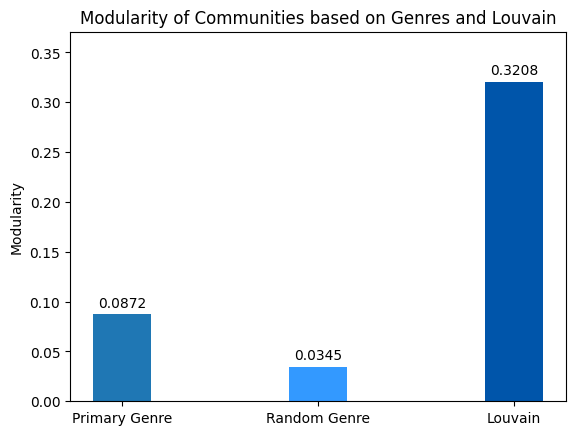

In [39]:
# Calculate modularity for primary genre communities
primary_modularity = modularity(G, primary_genre_communities.values())
print(f"Modularity (primary genre communities): {primary_modularity:.4f}")

# Calculate modularity for random genre communities
random_modularity = modularity(G, random_genre_communities.values())
print(f"Modularity (random genre communities): {random_modularity:.4f}")

# Calculate modularity for Louvain communities
louvain_modularity = modularity(G, louvain_communities)
print(f"Modularity (Louvain communities): {louvain_modularity:.4f}\n")

# Plot the modularity values for comparison, including Louvain community
labels = ['Primary Genre', 'Random Genre', 'Louvain']
modularity_values = [primary_modularity, random_modularity, louvain_modularity]
x = np.arange(len(labels))
width = 0.3
fig, ax = plt.subplots()
bars = ax.bar(x, modularity_values, width, color=['#1f77b4', '#3399ff', '#0055aa'])
ax.set_ylabel('Modularity')
ax.set_title('Modularity of Communities based on Genres and Louvain')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# Adding the value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
plt.ylim(0, max(modularity_values) + 0.05)
plt.show()


The **primary genre partition** has a modularity of M = 0.0872, while  **random genre partitions** get only M = 0.0349, which is aligned with what we discussed in the beggining of the notebook about the effect of genre in this metric. 

The **Louvain algorithm** achieves M = 0.3223 (around 4x the second highest). This reinforces the belief that while genres do create meaningful communities, they are far from mathematically optimal in terms of link density. 

This higher modularity value captured by the louvain algorithm may be exoplained by other factors other than genre, like geography, time periods, label companies, important hystorical events, or specific subcultures within rock music.

Visualizing the communities for each partition...



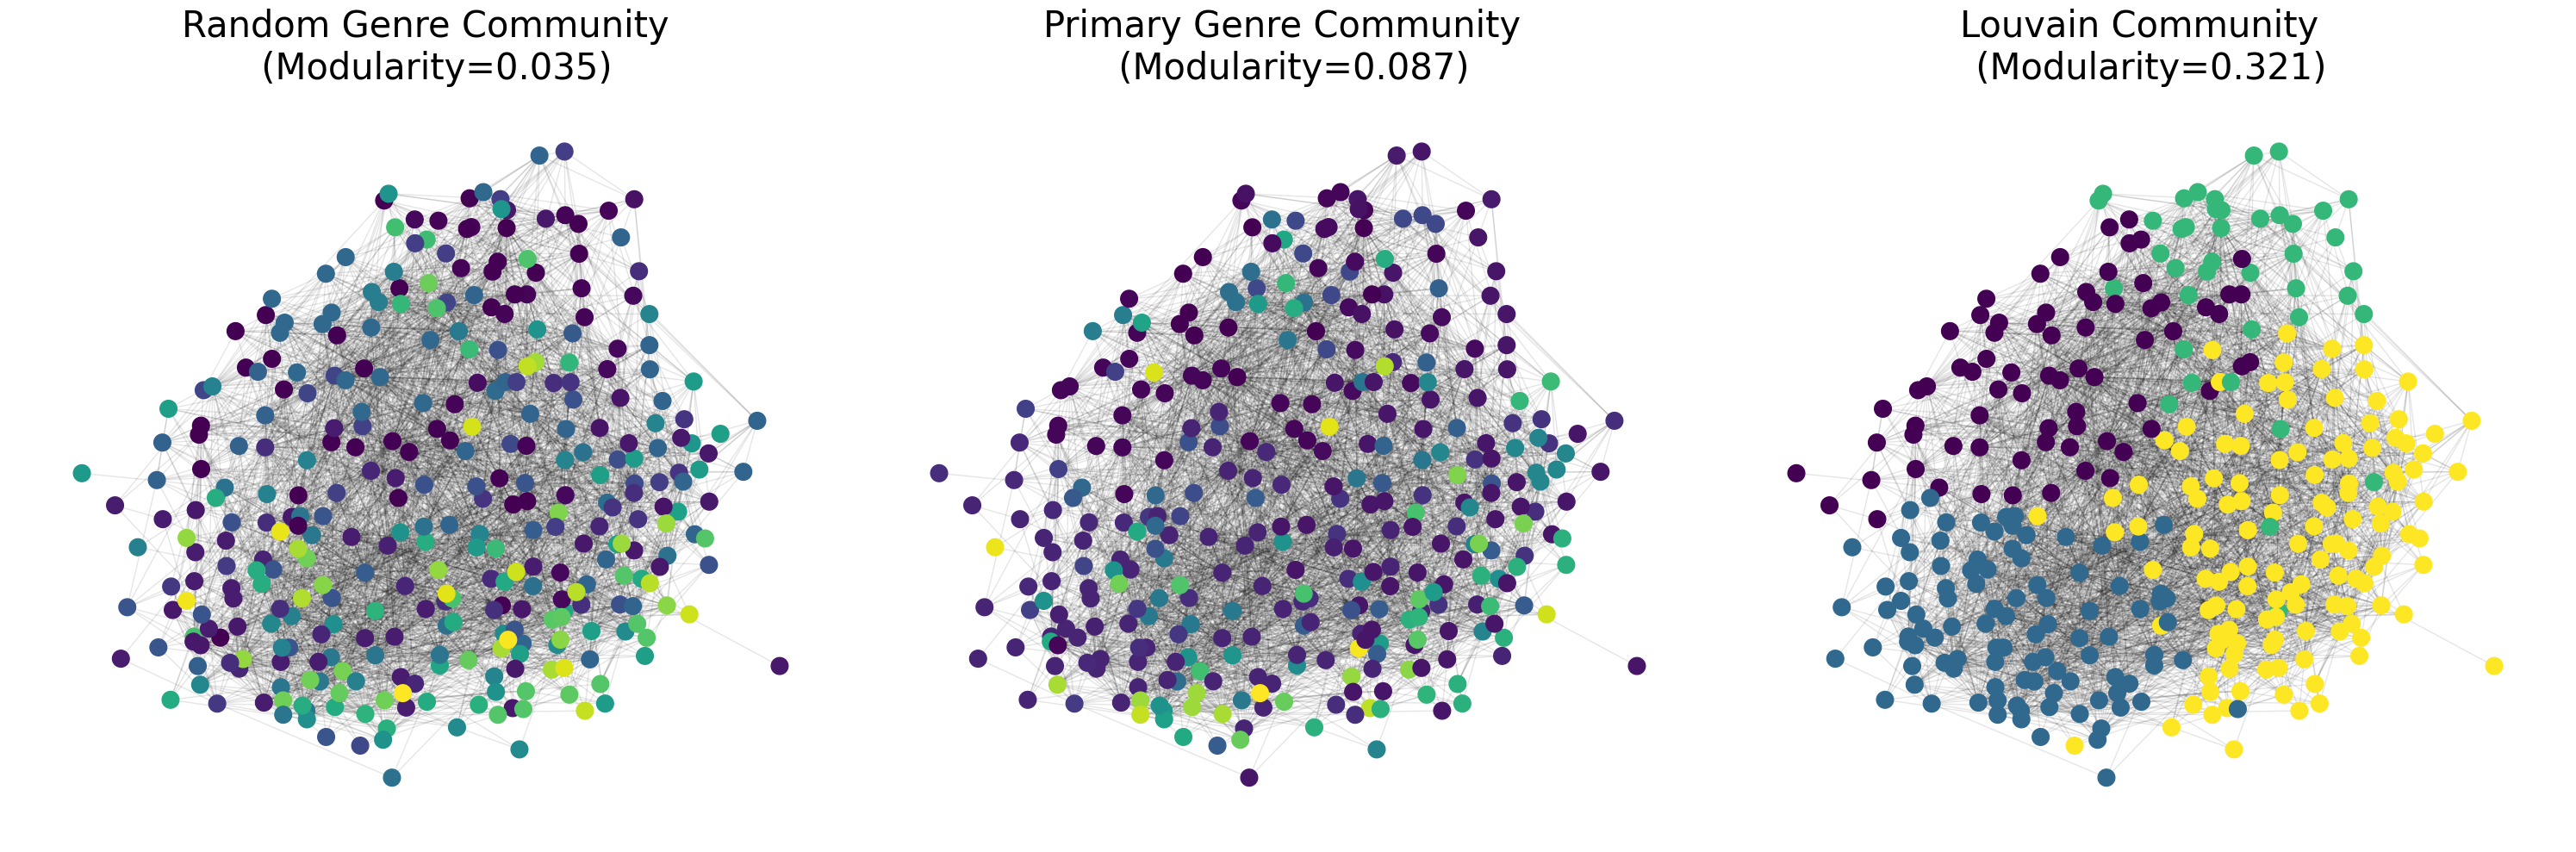

In [40]:
# Visualizing the communities for each partition
print("Visualizing the communities for each partition...\n")

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
pos = nx.forceatlas2_layout(G, max_iter=5000)

# Color maps for different partitions
primary_colors = [list(primary_genre_communities.keys()).index(primary_genre_partition[node]) for node in G.nodes()]
random_colors = [list(random_genre_communities.keys()).index(random_genre_partition[node]) for node in G.nodes()]
louvain_colors = [next(i for i, community in enumerate(louvain_communities) if node in community) for node in G.nodes()]  

# 1. Random genre communities
axes[0].set_title(f"Random Genre Community \n (Modularity={random_modularity:.3f})", fontsize=30)
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=random_colors, cmap=plt.cm.viridis, ax=axes[0])
nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axes[0])
axes[0].axis("off")

# 2. Primary genre communities
axes[1].set_title(f"Primary Genre Community \n (Modularity={primary_modularity:.3f})", fontsize=30)
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=primary_colors, cmap=plt.cm.viridis, ax=axes[1])
nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axes[1])
axes[1].axis("off")

# 3. Louvain communities
axes[2].set_title(f"Louvain Community \n (Modularity={louvain_modularity:.3f})", fontsize=30)
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=louvain_colors, cmap=plt.cm.viridis, ax=axes[2])
nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axes[2])
axes[2].axis("off")

plt.tight_layout()
plt.show()


Unlike the other two partitions, the Louvain partition clearly shows a spatial colour segregation, with each of the four communities forming different regions in the network. 

This is a visual way to observe the effects (or the presence) of a higher modularity in this partitioning method.

### Understanding the Modularity Gap

In order to better understand higher modularity the louvain communities, we can look at how they relate to the genre distribution of the artists. To do this, we analyse how present each of the top-10 most common genres are in each of these four communities.

If these louvain communities were directly equivalent to genre (which we can infer they aren't due to the difference in modularity results) they would show up as a very strong diagonal in the confusion matrix heatmap. This would show that each community effectively translates into one single genre of music that explains the increased links betwene this group.

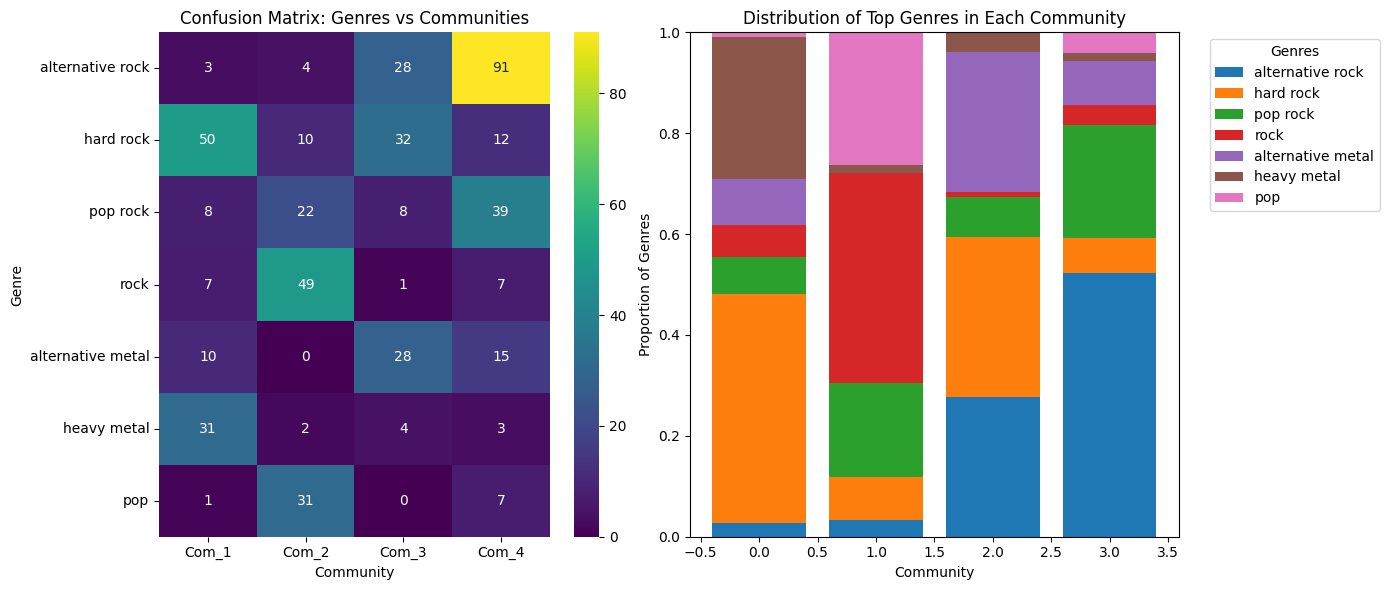

In [42]:
# Count all genre occurrences 
genre_counter = Counter()
for genres in artist_genres.values():
    genre_counter.update(genres)

# Select top 10 genres
top_genres = [g for g, _ in genre_counter.most_common(7)]

# Map genres to artists 
genre_to_artists = {}
for artist, genres in artist_genres.items():
    if not genres:
        continue
    for g in genres:
        genre_to_artists.setdefault(g, set()).add(artist)

# Build confusion matrix (genre vs community)
conf_matrix = np.zeros((len(top_genres), len(louvain_communities)), dtype=int)
for i, g in enumerate(top_genres):
    g_set = genre_to_artists.get(g, set())
    for j, comm in enumerate(louvain_communities):
        conf_matrix[i, j] = len(g_set & set(comm))

# Compute genre distribution (normalized per community)
genre_distribution = conf_matrix / conf_matrix.sum(axis=0, keepdims=True)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='viridis',
    xticklabels=[f'Com_{i+1}' for i in range(len(louvain_communities))],
    yticklabels=top_genres, ax=axes[0]
)
axes[0].set_title("Confusion Matrix: Genres vs Communities")
axes[0].set_xlabel("Community")
axes[0].set_ylabel("Genre")

# Stacked bar plot
bottom = np.zeros(len(louvain_communities))
for i, genre in enumerate(top_genres):
    axes[1].bar(
        range(len(louvain_communities)),
        genre_distribution[i, :],
        bottom=bottom,
        label=genre
    )
    bottom += genre_distribution[i, :]

axes[1].set_xlabel("Community")
axes[1].set_ylabel("Proportion of Genres")
axes[1].set_title("Distribution of Top Genres in Each Community")
axes[1].legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



If we look at Community 1 it is dominated by hard rock and heavy metal, which at least by name seem to share a certain quality. At the same time community 2 is further away from those "heavier" genres, being mostly rock and pop instead (we can see those as perhaps the most mainstream ones). On the other hand, community 4 has the highest concentration of artists from the same genre, in this case alternative rock (with also a considerable ammount of indie rock, two genres that could also indicate a certain proximity in style). Community 3 is perhaps the most varied or balanced one, without a single clear dominating genre. 

It's obvious by looking at the matrix (and the auxiliary bar plot on the right) that genres do not follow a 1-to-1 mapping with commmunities. This broad distribution explains why primary genre modularity (0.087) is much lower than Louvain modularity (0.322). The louvain algorithm is capturing patterns across genres that genre classification can't.


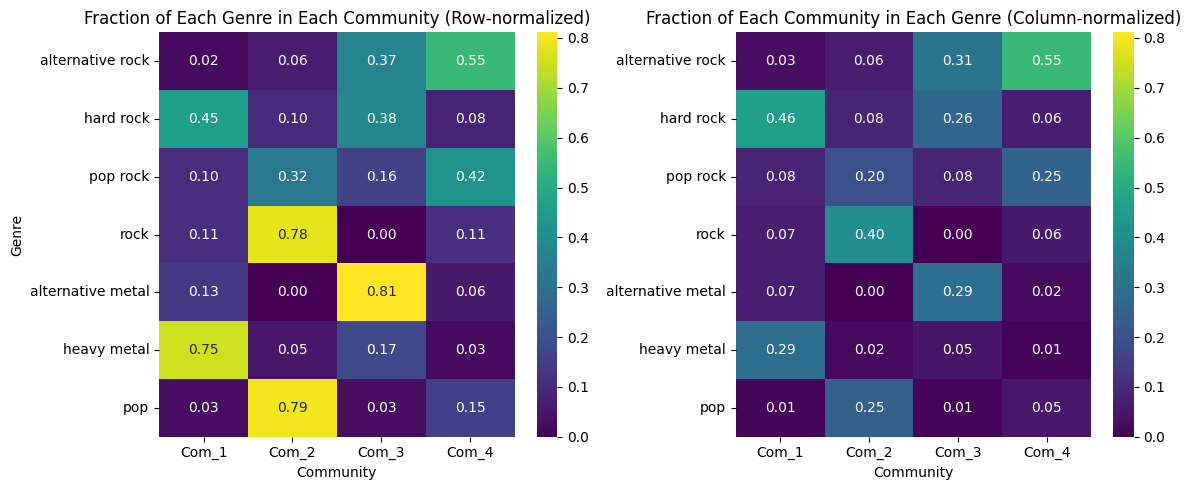

In [ ]:
# Row-normalized and column-normalized heatmaps with shared colorbar limits
cont_table = conf_matrix

row_norm = cont_table / cont_table.sum(axis=1, keepdims=True)
col_norm = cont_table / cont_table.sum(axis=0, keepdims=True)

vmax = max(row_norm.max(), col_norm.max())
vmin = min(row_norm.min(), col_norm.min())

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(row_norm, annot=True, fmt='.2f',
            yticklabels=top_genres, xticklabels=[f'Com_{i+1}' for i in range(cont_table.shape[1])],
            cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('Fraction of Each Genre in Each Community (Row-normalized)')
plt.xlabel('Community'); plt.ylabel('Genre')

plt.subplot(1,2,2)
sns.heatmap(col_norm, annot=True, fmt='.2f',
            yticklabels=top_genres, xticklabels=[f'Com_{i+1}' for i in range(cont_table.shape[1])],
            cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('Fraction of Each Community in Each Genre (Column-normalized)')
plt.xlabel('Community'); plt.ylabel('')
plt.tight_layout()
plt.show()


Normalizing the confusion matrices (by genre on the left and by community on the right) makes it easier to detect these relationships. Of course, the analysis done to the original matrix still applies to these new visualizations. 

It is however interesting, that while each community possesses significant contributions of more than one (possibly relate) genres, with none counting for much more than half the community, that's not the case for the genre normalized matrix on the left.

It appears that genres often concentrate more heavily in single communities, with 81% of alternative rock artists/bands being present in community 3. So, whereas communities are more genre diverse, genres seem to be more comunity specific, at least for some in the top 10. Some others however, don't show this behavior in such a pronounced way (like hard rock or pop rock).

In conclusion, Louvain communities are able to reach these optimal configurations of high modularity by connecting different but related genres that share dense interconnections.


### References

[11] NetworkX.org. (n.d.). networkx.algorithms.community.louvain.louvain_communities. NetworkX. Retrieved from https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html


[12] NetworkX developers. "networkx.algorithms.community.quality.modularity." NetworkX Documentation. https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html